# DLA simulation

---

In this notebook I am simulating [diffusion limited aggregation](https://en.wikipedia.org/wiki/Diffusion-limited_aggregation), and calculate the objects fractal dimension.


### Description of the simulation

Steps:

- start with an aggregate made of one point.
- release particles randomly on a circle outside the bounding box of the aggregate.
- simluate Brownian motion until the particle reaches the aggregate, or it goes outside a larger circle.

I decided to implement the aggregate as a dictionary. The keys are the coordinates, and the values show the indices of the particles (temporal order). I find it more intuitive and flexibe than storing a grid.

### Calculating the objects  fractal dimension

I calculate the objects fractal dimension using the [Correlation dimension](https://en.wikipedia.org/wiki/Correlation_dimension).

---

*Author: Dezso Ribli*

In [1]:
import matplotlib.pyplot as plt
import random
import math
import scipy
import scipy.optimize
import scipy.spatial
import numpy as np
from ipywidgets import interact
%matplotlib inline

In [2]:
def step(x,y):
    """Random 0,1 step in random xy direction."""
    if random.randint(0,1)==0: # x or y
        x+=random.choice([-1,1]) # back or forth
    else:
        y+=random.choice([-1,1])
    return x,y


def walk(agg):
    """Simlate Brown motion until attached, or out."""
    (xc,yc),r = seed_circle(agg) # calculate seed circle
    x,y = get_initial_pos(xc,yc,r) # start from afar
    while True: # I like to live dangerously
        x,y = step(x,y) # make one step
        if too_far(x,y,xc,yc,r): # check if we got too far
            break # if yes abandon this particle
        # check if next to aggregate
        if (((x-1,y) in agg) or  ((x+1,y) in agg) or
            ((x,y-1) in agg) or  ((x,y+1) in agg) or 
            ((x-1,y-1) in agg) or  ((x+1,y+1) in agg) or 
            ((x-1,y+1) in agg) or  ((x+1,y-1) in agg)):
            agg[(x,y)]=len(agg) # attach if yes
            break # finished
    return agg


def seed_circle(agg):
    """Get the seed circle."""
    x,y = zip(*agg.keys()) # get x,y lists from dict
    xmin,xmax,ymin,ymax = min(x),max(x),min(y),max(y) #bounds
    xc, yc = (xmin+xmax)/2, (ymin+ymax)/2 #center
    r = (((xmax-xmin)/2)**2 + ((ymax-ymin)/2)**2)**0.5 # radius
    return (xc,yc),r


def get_initial_pos(xc,yc,r):
    """Get inital position on seed circle."""
    ralf = 2* math.pi * random.random() # random angle
    # initial points on the circle
    x0 = int(xc + r*math.cos(ralf))
    y0 = int(yc + r*math.sin(ralf))
    return x0,y0


def too_far(x,y,x0,y0,r,d=10):
    """Check if the particle went too far."""
    return ((x-x0)**2 + (y-y0)**2)**0.5 > r+d


def grow(npart=10000):
    """Grow aggragate, try to attach npart points."""
    agg={(0,0):0} # 0th point at (0,0)
    for i in range(npart):
        agg = walk(agg) # try to attach
    return agg


def aggplot(N):
    """Plot aggragate after N particles added."""
    # get x,y points in the order they were added!
    x,y = zip(*sorted(agg, key=agg.get)) 
    plt.figure(figsize=(9,9)) # square plot
    plt.plot(x[:N],y[:N],'.')
    plt.xlim(min(x),max(x)) # fix size for better interactivity
    plt.ylim(min(y),max(y))
    plt.axis('off')
    plt.show() # somehow needed (?), its a workaround
    
    
def corr_dim(agg, plot=True):
    """Return and (plot) correlation dimension."""
    x,y = zip(*agg) # get x,y points 
    xy = np.column_stack((np.array(x),np.array(y))) # pack them
    dl = scipy.spatial.distance.pdist(xy) # get all pairwise dist
    dl = dl[dl<seed_circle(agg)[1]/3] # limit for the size of agg/3
    r = np.log10(np.sort(dl)) # log dist
    c = np.log10(np.arange(1,len(r)+1)) # log number of dist under r

    # fit linear on log log
    (a,b),pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b, r, c)

    if plot: #plot it if asked for
        plt.plot(r,c,'x')
        lab = 'coef = '+ "%.2f +/- %.2f"% (a, pcov[0,0]**0.5)
        plt.plot(r, a*r+b, label=lab)
        plt.xlabel('r')
        plt.ylabel('N(r)')
        plt.ylim(2) # lot of small dists, do not show them
        plt.legend()
        plt.grid()
    return a

### Plot one aggregate interactively

In [3]:
%%time
N = 10000
agg = grow(npart=N) # create the aggregate
print 'Out of ',N,' particles, ', len(agg), 'landed in the aggregate'

Out of  10000  particles,  2536 landed in the aggregate
CPU times: user 29 s, sys: 254 ms, total: 29.2 s
Wall time: 29.6 s


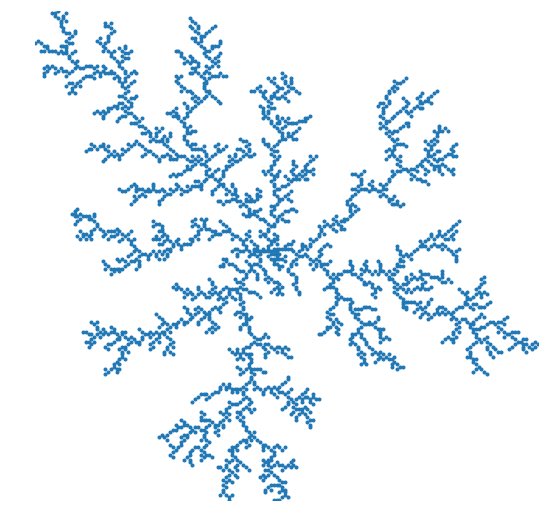

In [4]:
_=interact(aggplot,N=(0,len(agg),1)) # interactive plot for growing agg

## Calculate correlation dimension

### From one aggregate

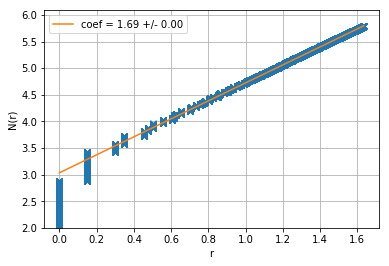

In [5]:
_=corr_dim(agg)

### Error estimation

- Please note, it may take some time. Reduce the number of partices, or the number of repetitions for faster results.

In [6]:
%%time
a = [corr_dim(grow(npart=10000),False) for i in range(10)]
print 'Correlation dimension','%.2f'%np.mean(a),'+/-','%.2f'%np.std(a)

Correlation dimension 1.68 +/- 0.02
CPU times: user 4min 57s, sys: 2.4 s, total: 5min
Wall time: 5min 2s


---

## Discussion

The simluated aggregate looks right, and the calculated dimension is less than 2 sigma